In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [8]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [9]:
%%time
path_figs = './figs/2Mstd5/'
Path(path_figs).mkdir(exist_ok = True, parents = True)
N,D = 2*10**6, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
kw_cluster =  {'f_class_name':'circle_class', 'centers': [0.5, 0.5], 'r_small': 0.2, 'r_big':0.4}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 5
stats = np.array([[1, std], [0, std], [1, std], [1, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:1369, Number of Points:2000000
CPU times: user 1.77 s, sys: 363 ms, total: 2.13 s
Wall time: 5.11 s


In [10]:
data

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,1,0,9.965060,1.816760,-8.148300
1,0.602763,0.544883,0,0,9.189899,0.518928,-8.670971
2,0.423655,0.645894,0,0,3.758011,-0.579457,-4.337468
3,0.437587,0.891773,1,1,1.389764,-1.482725,2.872489
4,0.963663,0.383442,0,0,-10.479152,6.160328,16.639480
...,...,...,...,...,...,...,...
1999995,0.076927,0.271817,0,0,4.558481,-3.107663,-7.666144
1999996,0.826662,0.335635,1,0,2.382933,-2.334834,-4.717767
1999997,0.930859,0.999898,0,0,-2.999037,8.870539,11.869577
1999998,0.794392,0.928825,0,1,-3.380580,-3.962592,0.582012


In [11]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,4.997836e-01,5.001988e-01,3.774610e-01,5.001005e-01,8.142636e-01,8.151898e-01,3.786323e-01
std,2.887267e-01,2.886267e-01,4.847518e-01,5.000001e-01,5.012017e+00,5.016939e+00,7.086182e+00
min,1.637144e-07,2.516784e-08,0.000000e+00,0.000000e+00,-2.659529e+01,-2.374868e+01,-3.689058e+01
25%,2.495544e-01,2.502948e-01,0.000000e+00,0.000000e+00,-2.565503e+00,-2.567915e+00,-4.405667e+00
50%,4.999703e-01,5.003810e-01,0.000000e+00,1.000000e+00,8.163050e-01,8.171418e-01,3.796200e-01
75%,7.499998e-01,7.500191e-01,1.000000e+00,1.000000e+00,4.196194e+00,4.201078e+00,5.159550e+00
max,9.999993e-01,9.999997e-01,1.000000e+00,1.000000e+00,2.433922e+01,2.545277e+01,3.647708e+01


In [12]:
#mpl.style.use(['seaborn-paper'])
#mpl.rcParams.update(mpl.rcParamsDefault)


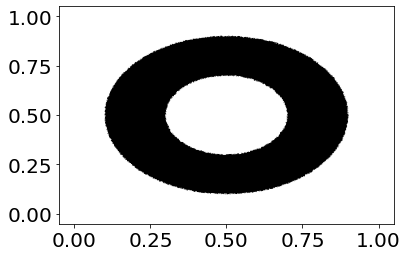

In [13]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [14]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 2h 13min 26s, sys: 23.8 s, total: 2h 13min 50s
Wall time: 5h 1min 52s


In [15]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,1,0,9.965060,1.816760,-8.148300,1,0.486333,-9.478727
1,0.602763,0.544883,0,0,9.189899,0.518928,-8.670971,0,1.391655,-7.798244
2,0.423655,0.645894,0,0,3.758011,-0.579457,-4.337468,1,1.010634,-2.747378
3,0.437587,0.891773,1,1,1.389764,-1.482725,2.872489,0,0.582260,0.807504
4,0.963663,0.383442,0,0,-10.479152,6.160328,16.639480,0,1.293432,11.772584


### Model performance

In [16]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C                                                  
0         0  1.001391  1.001315  1.001997 -0.000076  0.000606
          1 -0.000802  1.005553  1.002358  1.006354  1.003160
1         0  1.005460  1.002306  0.963021  0.003155  0.042439
          1  1.004695  0.009913  0.064400  0.994782  0.940295

### Apply clustering 

In [17]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 10h 27min 7s, sys: 26min, total: 10h 53min 7s
Wall time: 5h 30min 16s


In [18]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,1,0,9.965060,1.816760,-8.148300,1,0.486333,-9.478727,982,675
1,0.602763,0.544883,0,0,9.189899,0.518928,-8.670971,0,1.391655,-7.798244,762,203
2,0.423655,0.645894,0,0,3.758011,-0.579457,-4.337468,1,1.010634,-2.747378,866,271
3,0.437587,0.891773,1,1,1.389764,-1.482725,2.872489,0,0.582260,0.807504,1200,1166
4,0.963663,0.383442,0,0,-10.479152,6.160328,16.639480,0,1.293432,11.772584,553,459


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [19]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [20]:
box

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,-0.079133,1409.0,1.0,0.000705
1,1,-0.172258,1451.0,1.0,0.000726
2,2,-0.196278,1399.0,1.0,0.000700
3,3,0.328019,1390.0,1.0,0.000695
4,4,-0.194898,1489.0,1.0,0.000745
...,...,...,...,...,...
1364,1364,0.426797,1486.0,1.0,0.000743
1365,1365,0.241997,1409.0,1.0,0.000705
1366,1366,0.295582,1459.0,1.0,0.000730
1367,1367,-0.200389,1447.0,1.0,0.000723


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


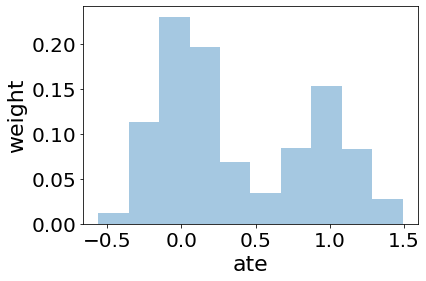

In [21]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 10
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values, hist_kws = {'weights':box['Box-Weights'].values} , bins=bins, kde = False,ax = ax)
ax.set_xlabel('ate')
ax.set_ylabel('weight')
fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


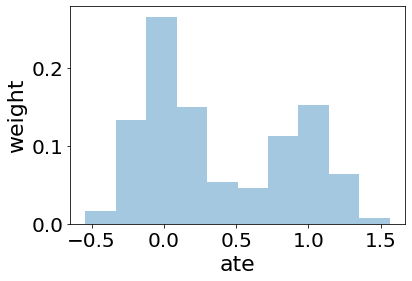

In [22]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans['Kmeans-ATT'], hist_kws={'weights':kmeans['Kmeans-Weights'].values},
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ate')
ax.set_ylabel('weight')
fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


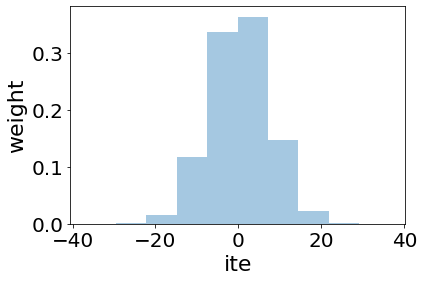

In [23]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = bins,hist_kws={'weights': np.ones(len(data))/len(data)},
                  kde = kde, ax = ax)
ax.set_xlabel('ite')
ax.set_ylabel('weight')
fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [24]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,1369.00000,1369.000000,1369.000000,1369.000000,1369.000000
mean,684.00000,0.378275,1460.920380,0.976358,0.000730
std,395.34057,0.502365,37.097551,0.080778,0.000019
min,0.00000,-0.561265,1345.000000,0.519515,0.000673
25%,342.00000,-0.034290,1435.000000,1.000000,0.000718
50%,684.00000,0.182619,1460.000000,1.000000,0.000730
75%,1026.00000,0.892859,1486.000000,1.000000,0.000743
max,1368.00000,1.493165,1590.000000,1.000000,0.000795


### Calculate ATT per Cluster not known Model Calculated CF

In [25]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


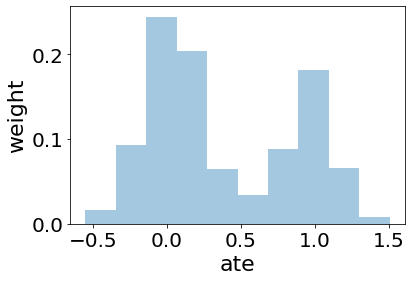

In [26]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box2['Box-ATT'], hist_kws={'weights':box2['Box-Weights'].values},bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ate')
ax.set_ylabel('weight')
fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


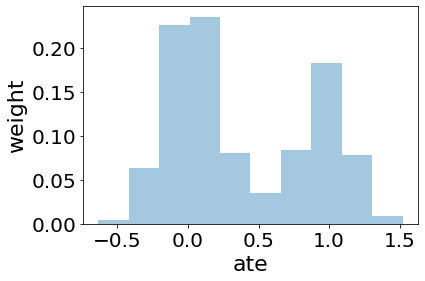

In [27]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans2['Kmeans-ATT'], hist_kws={'weights':kmeans2['Kmeans-Weights'].values},
             bins = bins, kde = kde, ax = ax)
ax.set_xlabel('ate')
ax.set_ylabel('weight')
fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


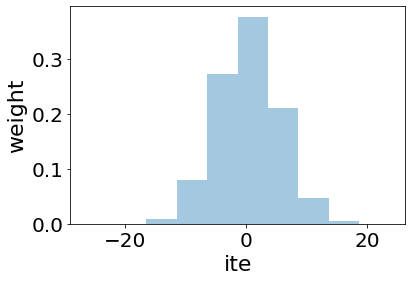

In [28]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde, ax = ax, hist_kws={'weights': np.ones(len(data))/len(data)})

ax.set_xlabel('ite')
ax.set_ylabel('weight')
fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Weighted Kmeans 2-Clustering

In [29]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names2 = ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

for dd, name, name2,w in zip(all_data, names, names2,weights):
    kmeans_clustering(dd, clusters = 2, col_select = [name2], 
                      cluster_name = name, fit_kwargs={'sample_weight':dd[w].values} )

CPU times: user 21.5 s, sys: 71.7 ms, total: 21.6 s
Wall time: 10.4 s


In [30]:
data2 = data.copy()

In [31]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,1,0,9.965060,1.816760,-8.148300,1,0.486333,-9.478727,982,675
1,0.602763,0.544883,0,0,9.189899,0.518928,-8.670971,0,1.391655,-7.798244,762,203


### 2 Clustering in the ITEs

In [32]:
data2,_ = kmeans_clustering(data2,clusters = 2, cluster_name = 'ITE-CTrue',col_select = ['ITE'] )
data2,_ = kmeans_clustering(data2,clusters = 2, cluster_name = 'ITE-CGDBR',col_select = ['ITE-GDBR'] )

### Clustering for Drawing 
1. Apply Box clustering to separate the space in K clusters
2. Group by this clusters and get the Average C2-Avg from the 2 clustering
3. Color each box with the C2-Avg corresponding to each box

In [33]:
K = 10**4
data2,_ = box_clustering(data2, clusters = K, cluster_name = 'C2-Avg', col_select = col_select)

In [34]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-CTrue,ITE-CGDBR,C2-Avg
0,0.548814,0.715189,1,0,9.965060,1.816760,-8.148300,1,0.486333,-9.478727,982,675,0,0,7154
1,0.602763,0.544883,0,0,9.189899,0.518928,-8.670971,0,1.391655,-7.798244,762,203,0,0,5460


In [35]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,-0.079133,1409.0,1.0,0.000705,0
1,1,-0.172258,1451.0,1.0,0.000726,0


### Merge 2 Clustering with initial data

In [36]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

### Find Average 2 Clustering per draw cluster and merge them in the initial dataset

In [37]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2',
            #    'Agglo2-Cl2','ITE-CTrue', 'ITE-CGDBR']
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 
               'Kmeans2-Cl2','ITE-CTrue', 'ITE-CGDBR']

avg_c = data2.groupby('C2-Avg', sort = True)[class_names].mean().reset_index()
data2 = data2.merge(avg_c, on = 'C2-Avg', how = 'left', suffixes=("","y"))

In [38]:
avg_c.head()

,C2-Avg,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,ITE-CTrue,ITE-CGDBR
0,0,0.0,0.0,0.0,0.0,0.459596,0.484848
1,1,0.0,0.0,0.0,0.0,0.463687,0.469274
2,2,0.0,0.0,0.0,0.0,0.457014,0.429864
3,3,0.0,0.0,0.0,0.0,0.492228,0.497409
4,4,0.0,0.0,0.0,0.0,0.502392,0.483254


In [39]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-CTrue,ITE-CGDBR,C2-Avg,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2y,Kmeans-Cl2y,Box2-Cl2y,Kmeans2-Cl2y,ITE-CTruey,ITE-CGDBRy
0,0.548814,0.715189,1,0,9.965060,1.816760,-8.148300,1,0.486333,-9.478727,982,675,0,0,7154,1,1,1,1,1.0,1.0,1.0,1.0,0.539906,0.521127
1,0.602763,0.544883,0,0,9.189899,0.518928,-8.670971,0,1.391655,-7.798244,762,203,0,0,5460,0,0,0,0,0.0,0.0,0.0,0.0,0.478723,0.489362


### Plot reconstruction of data

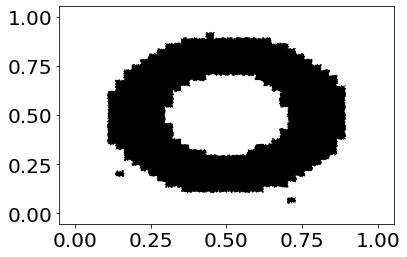

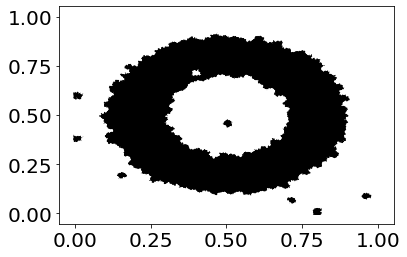

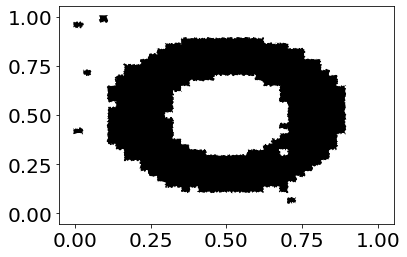

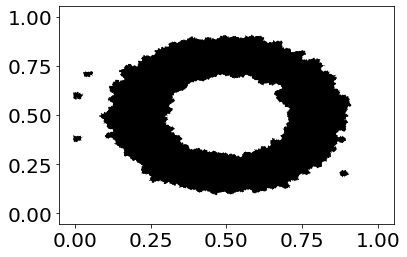

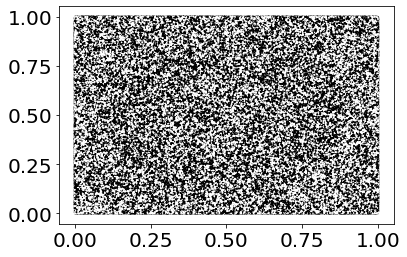

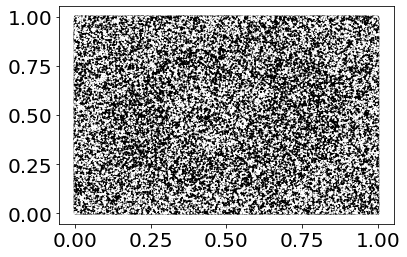

CPU times: user 21min 52s, sys: 6.82 s, total: 21min 59s
Wall time: 52min 22s


In [40]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']


path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
class_names2 = [name+'y' for name in class_names]
use_poly = False
for name in class_names:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

### Plot same as above but with box averaging

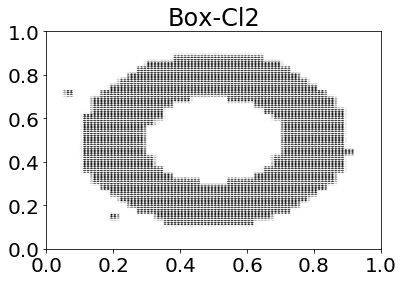

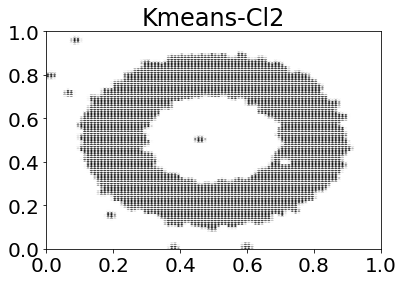

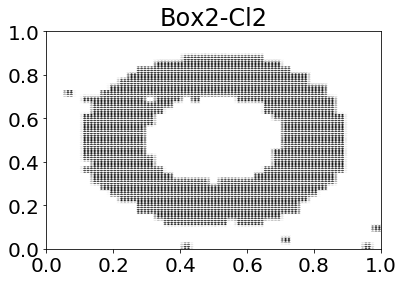

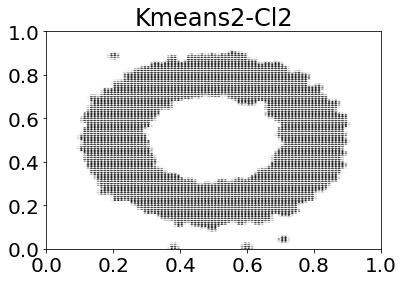

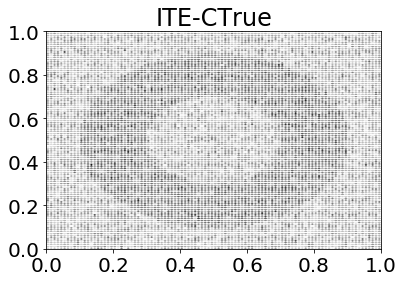

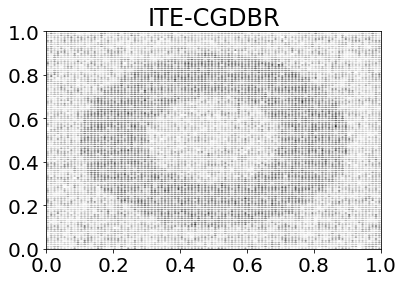

CPU times: user 7.46 s, sys: 203 ms, total: 7.66 s
Wall time: 21.5 s


In [41]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']



class_names2 = [name+'y' for name in class_names]
use_poly = True
for name in class_names:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 0.25)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
       # ax.figure.colorbar(coll)
    ax.set_title(name)
    #fig.colorbar(sc)

    plt.show()
    

### homogeneity experiment

clusters = [4, 16, 25, 100]
clustering_algo = ['box_clustering', 'kmeans_clustering', 'agglomerative_clustering']

result = get_homogeneity(data.copy(),clusters = clusters, clustering_algo = clustering_algo, col_select = col_select)

pd.DataFrame(result)